In [26]:
# Importer les bibliothèques nécessaires

# Pour manipuler les bases de données et les graphes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pour le ML
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [19]:
# Charger le jeu de données
path = "/home/onyxia/work/projet-python/"
#enlever work si nécessaire
file_name1 = "dataset_complet_part_1.csv"
file_name2 = "dataset_complet_part_2.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2])

df = df.loc[df['an'] == 2019]
df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

df = df.drop(columns=['Num_Acc','an','adr','lat','long','lartpc','larrout','com','gps','voie','dep','v2','pr','pr1'])
#ici on enlève an car on ne regarde que pour 2019
df['hrmn'] = df['hrmn'].str.split(':').str[0].astype(int)
df['nbv'] = df['nbv'].astype(int)

df.to_csv('XGboost.csv', index=False)

y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

In [20]:
print(X.head())
print(y.head())
print(features)

        mois  jour  hrmn  lum  agg  int  atm  col  catr   v1  circ  nbv  vosp  \
362128  11.0  30.0     1  4.0  1.0  1.0  1.0  2.0   1.0  0.0   3.0   10   0.0   
362129  11.0  30.0     2  3.0  1.0  1.0  1.0  6.0   1.0  0.0   1.0    2   0.0   
362130  11.0  28.0    15  1.0  1.0  1.0  1.0  4.0   1.0  0.0   3.0    8   0.0   
362131  11.0  30.0    20  5.0  1.0  1.0  1.0  4.0   1.0  0.0   3.0    5   0.0   
362132  11.0  30.0     4  3.0  1.0  1.0  1.0  2.0   1.0  0.0   1.0    3   0.0   

        prof  plan  surf  infra  situ   vma  
362128   1.0   2.0   1.0    2.0   1.0  70.0  
362129   4.0   2.0   1.0    0.0   1.0  70.0  
362130   1.0   3.0   1.0    0.0   1.0  90.0  
362131   1.0   1.0   1.0    0.0   1.0  90.0  
362132   1.0   3.0   1.0    2.0   1.0  90.0  
362128    0
362129    0
362130    0
362131    0
362132    0
Name: grav, dtype: int64
Index(['mois', 'jour', 'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'v1',
       'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', '

In [21]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# Définir les paramètres du modèle XGBoost
params = {
    'objective': 'binary:logistic',  # Définit l'objectif (classification multi-classe)
    'eval_metric': 'error',  # Métrique d'évaluation
    'max_depth': 3,  # Profondeur maximale de l'arbre
    'eta': 0.1,  # Taux d'apprentissage
    'learning_rate': 0.1,
    'subsample': 0.7,  # Pourcentage d'échantillons utilisés pour former chaque arbre
    'colsample_bytree': 0.7  # Pourcentage de fonctionnalités utilisées pour former chaque arbre
}

# Convertir les données en DMatrix (format requis par XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [27]:
# Définir les paramètres à rechercher
param_grid = {
    'max_depth': [3, 10, 20],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.7, 0.8, 0.9]
}

# Créer un modèle XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# Créer une instance de GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleur score : ", grid_search.best_score_)

Meilleurs paramètres trouvés :  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}
Meilleur score :  0.7562243462663544


In [29]:
# Entraîner le modèle XGBoost
num_round = 100  # Nombre d'itérations d'entraînement
model = xgb.train(params, dtrain, num_round)

# Convertir les prédictions en classes (0 ou 1)
predictions = [round(value) for value in predictions]

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Afficher le rapport de classification
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.7624065261726717
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      7524
           1       0.71      0.58      0.64      4244

    accuracy                           0.76     11768
   macro avg       0.75      0.72      0.73     11768
weighted avg       0.76      0.76      0.76     11768



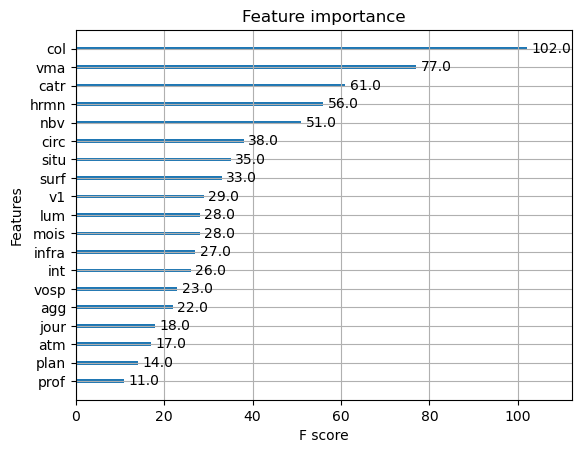

In [30]:
xgb.plot_importance(model)
plt.show()